# Timing recording in a callback
The aim of this file is to identify the critical part of recording long tracks. In orded to do this, I will try to time the recording and find the problematic part.

## Initialization
First, lets initialize the classes and libs I use in my project.

In [63]:
# types/dev
from typing import Optional
import numpy.typing as npt
# libs
import numpy as np
import timeit
from random import randint
import matplotlib.pyplot as plt


SAMPLERATE = 44100  # [samples per second]
BLOCKSIZE = 100   # [samples]
CHANNELS = 2
LATENCY = 0

DTYPE = np.int16
STR_DTYPE = "int16"

METRONOME_SAMPLE_PATH = "lib/samples/metronome.wav"


class Track():
    """A base class for other types of track.
    """

    def __init__(self, data: npt.NDArray[DTYPE]) -> None:
        """Initialize a new instance of Track.

        Args:
            data (npt.NDArray[DTYPE], optional): The audio data. Defaults to np.empty((0, CHANNELS), dtype=DTYPE).
        """
        self.data = data

class RecordedTrack(Track):
    """A naive track which is currently being recorded. 
    Does not check whether the values it holds make sense (stop_rec_time can be before start_rec_time etc.). 
    """

    def __init__(self, data: npt.NDArray[DTYPE] = np.empty((0, CHANNELS), dtype=DTYPE)) -> None:
        """Initialize an instance of recorded track.

        Args:
            data (npt.NDArray[DTYPE], optional): The audio data. Defaults to np.empty((0, CHANNELS), dtype=DTYPE).
        """
        super().__init__(data)
        self.first_frame_time: Optional[int] = None
        self.start_rec_time: Optional[int] = None
        self.stop_rec_time: Optional[int] = None

    def join(self, data: npt.NDArray[DTYPE]) -> None:
        """Append the data to data property.

        Args:
            data (npt.NDArray[DTYPE]): The audio data to be appended.
        """
        self.data = np.concatenate([self.data, data])

Now lets extract the tested part from the callback:
```py
if self._recording:
    self._recorded_track.append(data=indata)
```

In [83]:
class LoopStreamManager():
    def __init__(self) -> None:
        self._recording = True
        self._recorded_track = RecordedTrack()

    def rec_callback(self, indata: npt.NDArray[DTYPE]) -> None:
        if self._recording:
            self._recorded_track.join(data=indata)

It is necessary to determine the `repeat` number. The callback failed after about twenty seconds of recording, so it was called (44100/100)*20 = 8820 times. Lets round that to 9000.

In [71]:
repeat = 9000
indata = np.array([[randint(-32768, 32767), randint(-32768, 32767)] for i in range(100)], dtype=DTYPE)
lsm = LoopStreamManager()

code = """lsm.rec_callback(indata=indata)"""

times = timeit.repeat(stmt=code, number=1, repeat=repeat, globals=globals())

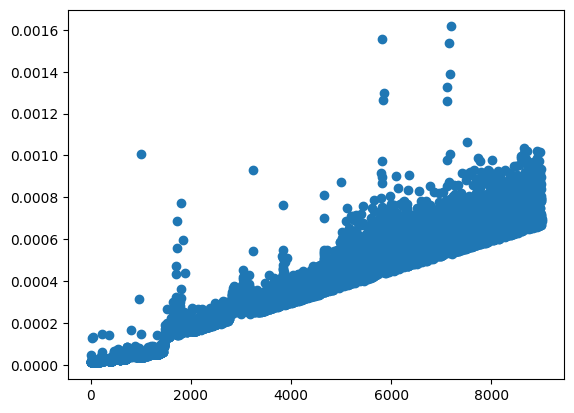

In [72]:
x = [i for i in range(repeat)]
y = times

fig, ax = plt.subplots()

ax.scatter(x, y)
plt.show()

## Evaluation
So: is that a lot? Is that critical?

In my previous timing, I have assumed that my callback runs at 100 Hz. However, the reality is different: my callback has 100 frames, so it runs at 441 Hz (44100/100). Therefore, it has approximately 2.22*10^-3 s (0.00226 s).

As the chart above shows, while in the beginning the recording action does not consume an unproportional amount of time, after twenty seconds of recording it can regularly consume as much as a half of the callback's time.

## Solutions
The np.concatenate function has (as I use it) _O(n)_, as every time something is appended, the array is resized and the all the elements need to be copied. One solution is to use python lists instead, as adding to them has approximately _O(1)_. This will have the drawback of concatenating in the post production - however, in my program, this happens in a separate thread. Lets test this solution:

In [84]:
class FixedRecordedTrack():
    """A naive track which is currently being recorded. 
    Does not check whether the values it holds make sense (stop_rec_time can be before start_rec_time etc.). 
    """

    def __init__(self) -> None:
        """Initialize an instance of recorded track.

        Args:
            data (npt.NDArray[DTYPE], optional): The audio data. Defaults to np.empty((0, CHANNELS), dtype=DTYPE).
        """
        self.data = []
        self.first_frame_time: Optional[int] = None
        self.start_rec_time: Optional[int] = None
        self.stop_rec_time: Optional[int] = None

    def join(self, data: npt.NDArray[DTYPE]) -> None:
        """Append the data to data property.

        Args:
            data (npt.NDArray[DTYPE]): The audio data to be appended.
        """
        self.data.append(data)


class FixedLoopStreamManager():
    def __init__(self) -> None:
        self._recording = True
        self._recorded_track = FixedRecordedTrack()

    def rec_callback(self, indata: npt.NDArray[DTYPE]) -> None:
        if self._recording:
            self._recorded_track.join(data=indata)

In [73]:
repeat = 9000
indata = np.array([[randint(-32768, 32767), randint(-32768, 32767)] for i in range(100)], dtype=DTYPE)
lsm = FixedLoopStreamManager()

code = """lsm.rec_callback(indata=indata)"""

times = timeit.repeat(stmt=code, number=1, repeat=repeat, globals=globals())

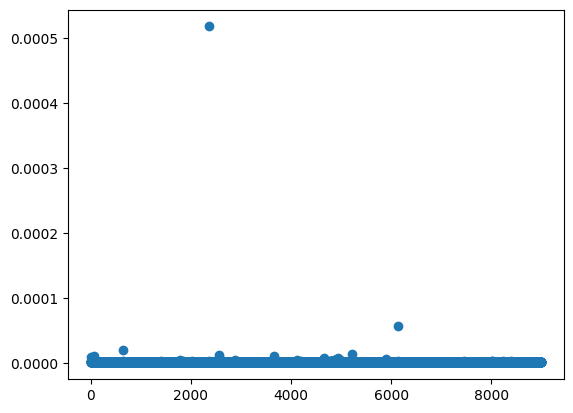

In [74]:
x = [i for i in range(repeat)]
y = times

fig, ax = plt.subplots()

ax.scatter(x, y)
plt.show()

And it is indeed _O(1)_!

As for the conversion afterwards...

In [85]:
repeat = 900
indata = np.array([[randint(-32768, 32767), randint(-32768, 32767)] for i in range(100)], dtype=DTYPE)
lsm = FixedLoopStreamManager()

code = """np.concatenate(lsm._recorded_track.data)"""

times = []
for i in range(repeat):
    lsm.rec_callback(indata=indata)
    time = timeit.timeit(stmt=code, number=1, globals=globals())
    times.append(time)

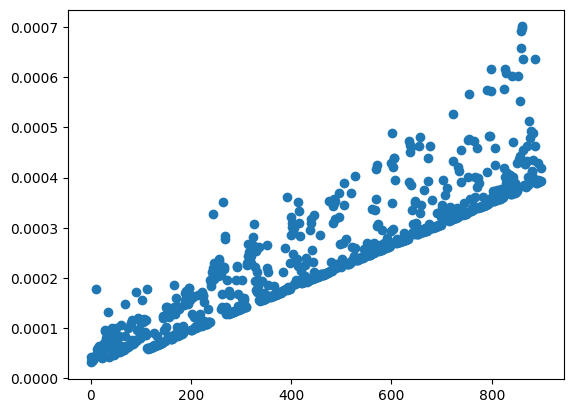

In [86]:
x = [i for i in range(repeat)]
y = times

fig, ax = plt.subplots()

ax.scatter(x, y)
plt.show()

In [94]:
lsm = FixedLoopStreamManager()
# 9000000 callbacks = 20408 s = 5.66 h
for i in range(9000000):
    lsm.rec_callback(indata=indata)

time = timeit.timeit(stmt=code, number=1, globals=globals())
print(time)

5.63126668599989


So even if I recorded for almost six hours, the conversion afterwards would take only about six seconds.